# Description

## SFC Requests Placed

Compute the requests placed

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the Results folder inside the docker container
path_results = "../logs"

# hue_order = ["Random", "Greedy", "Speed"]

hue_order = ["Domain", "Auction", "Speed"]

hue_label = ["Single Domain", "Auction", "SPEED"]

# hue_order = ["Random", "Domain", "Auction", "Speed"]

def connect_dataframe(pda, num_requests, label, rnd):
    global hue_order
    pda['Num_Requests'] = num_requests
    pda['Label'] = label
    pda['Round'] = rnd

    return pda

def load_data():

    num_requests = dict()

    experiments = list(filter(lambda x: os.path.isdir(os.path.join(path_results, x)), os.listdir(path_results)))

    requests = []
    data_aggregation = []
    for exp in experiments:
        aux = exp.split("_")
        num_requests[int(aux[0])] = int(aux[0])

        for alg in hue_order:
            # distributed placement            
            if alg == "Auction" or alg == "Domain" :
                
                exp_file = "{}/{}/{}/placement.csv".format(path_results, exp, alg.lower())
                
                proc_data = pd.read_csv(exp_file, sep=';')
                
                proc_data.replace("PLACEMENT_SUCCESS", "SUCCESS", inplace=True)                
                proc_data.replace("PLACEMENT_FAIL", "FAIL", inplace=True)            

                if alg == "Domain":
                    alg = "Single Domain"
                    
                requests.append(connect_dataframe(
                    proc_data,
                    int(aux[0]),
                    alg,
                    int(aux[1]),
                ))
                
            else:                
                exp_file = "{}/{}/{}/distributed_placement.csv".format(path_results, exp, alg.lower())
                
                exp_file2 = "{}/{}/{}/data_aggregation.csv".format(path_results, exp, alg.lower())
                
                proc_data1 = pd.read_csv(exp_file, sep=';')
                
                if alg == "Speed":
                    alg = "SPEED"
                    
                requests.append(connect_dataframe(
                    proc_data1,
                    int(aux[0]),
                    alg,
                    int(aux[1]),
                ))
        
                # data aggregation
                proc_data2 = pd.read_csv(exp_file2, sep=';')
                data_aggregation.append(connect_dataframe(
                    proc_data2,
                    int(aux[0]),
                    alg,
                    int(aux[1]),
                ))

    o = list(num_requests.keys())

    data = {
        'requests': requests,
        'data_aggregation': data_aggregation,
        'order': o
    }

    return data

# pd.set_option('display.max_rows', 20)
aux = load_data()
# display(aux)

# Process Data

Return the percentage of success placement

In [79]:
def process_data():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        # df = services.loc[(services['Event'] == "SUCCESS") | (services['Event'] == "FAIL")]
        services_processed.append(services)        

    res = pd.concat(services_processed)

    # grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).size().reset_index(name='Count')
    
    # grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).size().reset_index(name='Count')
    
    # grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).count().reset_index()

    grouped_data = res.groupby(['Label', 'Num_Requests', 'Round'])["Event"].value_counts(normalize=True).mul(100).unstack("Event").fillna(0).reset_index()
  
    # grouped_data.loc[grouped_data['SUCCESS'] > 100, 'SUCCESS'] = grouped_data['SUCCESS'] * 1.5
    # 
    # grouped_data.loc[grouped_data['SUCCESS'] > 100, 'SUCCESS'] = 1  
    # display(grouped_data.loc[grouped_data['Label'] == 'Speed', 'SUCCESS'])
    #
    
    # grouped_data["percentage"] = (grouped_data['Count'] / grouped_data['Num_Requests'])
        
    return grouped_data

load_data()
df_summed = process_data()
df_summed

Event,Label,Num_Requests,Round,FAIL,SUCCESS
0,Auction,5,0,0.000000,100.000000
1,Auction,5,1,0.000000,100.000000
2,Auction,5,2,20.000000,80.000000
3,Auction,5,3,0.000000,100.000000
4,Auction,5,4,0.000000,100.000000
...,...,...,...,...,...
143,Single Domain,100,5,90.476190,9.523810
144,Single Domain,100,6,94.915254,5.084746
145,Single Domain,100,7,70.967742,29.032258
146,Single Domain,100,8,97.000000,3.000000


## Service Placed

Print the service success rate placement graph

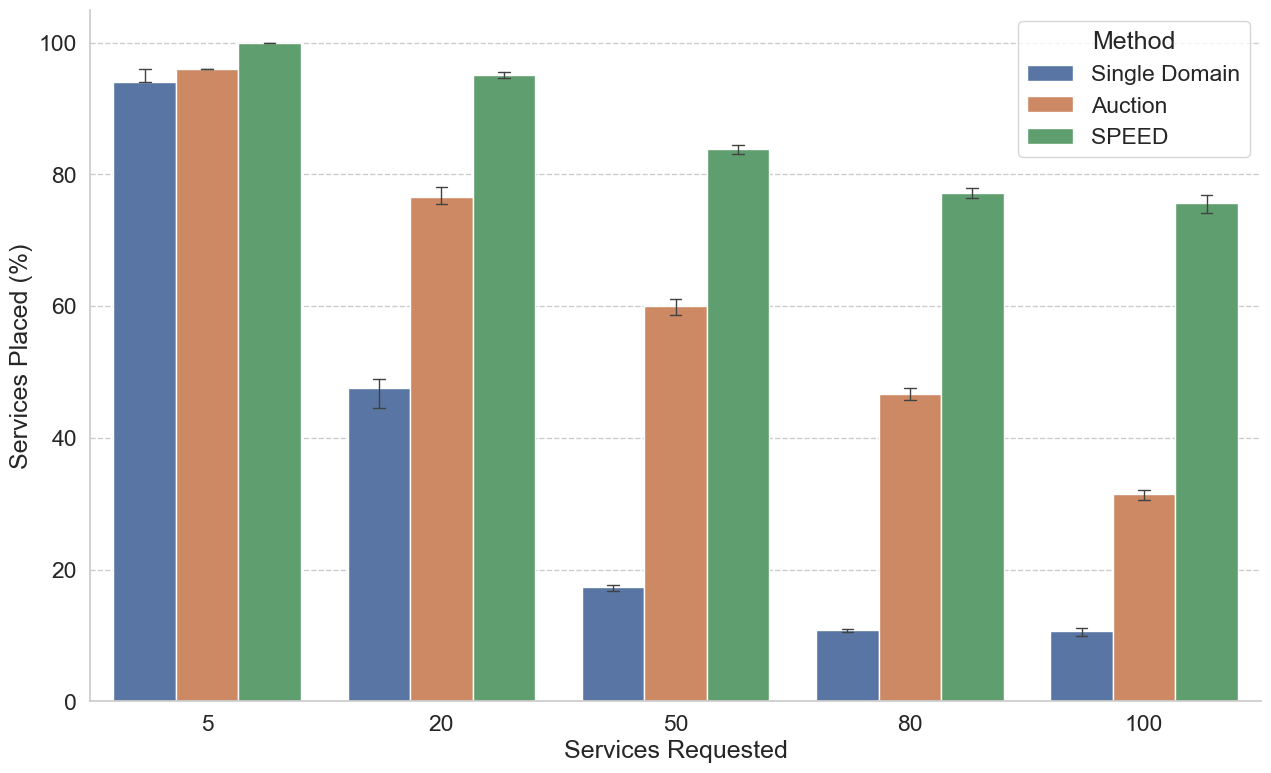

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_label,
    x="Num_Requests",
    y="SUCCESS",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 20),
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Services Placed (%)")
plt.legend(loc='upper right', title='Method')

plt.show()

g.figure.savefig(fname='./services_placed.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

In [81]:
def process_data_cost():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests','Round']).mean(['Cost']).reset_index()

    grouped_data["cost_dollar"] = (grouped_data['Cost'] / 1000)
    # grouped_data["cost_dollar"] = (grouped_data['Cost'] / 1)

    return grouped_data

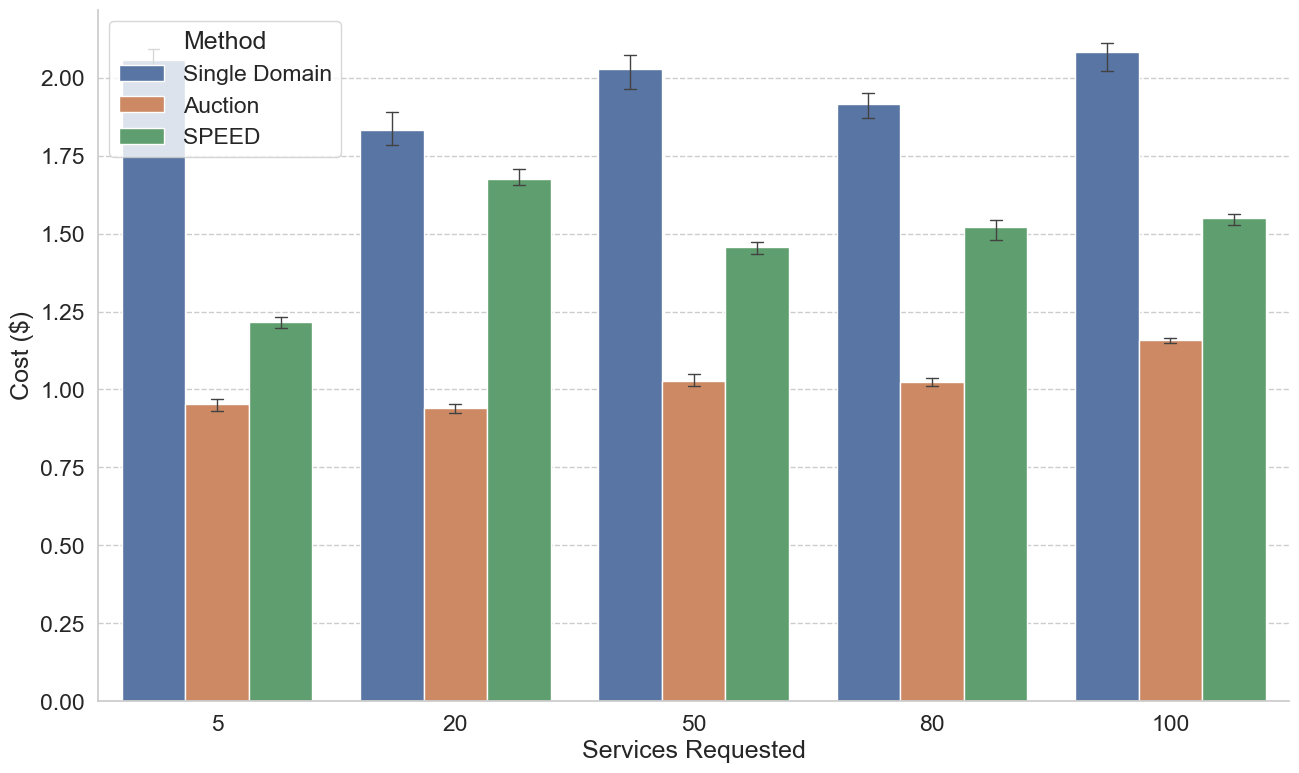

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_cost()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_label,
    x="Num_Requests",
    y="cost_dollar",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 20),    
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Cost ($)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./services_cost.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

In [84]:
def process_data_placement_time():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS") & (services['Label'] == "SPEED")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests'],  observed=True).mean(["Placement_Time"]).reset_index()

    return grouped_data

df_summed = process_data_placement_time()
df_summed.describe()

,Num_Requests,Time,Cost,Round,Placement_Time
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,51.000000,2898.922251,1473.232696,4.533350,30.071101
std,39.749214,501.084424,163.942652,0.062047,2.613097
min,5.000000,2447.454897,1215.200000,4.439791,27.802835
25%,20.000000,2533.554859,1459.561201,4.500000,28.852665
50%,50.000000,2813.637413,1483.401254,4.565831,29.240838
75%,80.000000,2994.424084,1547.268041,4.577367,29.919169
max,100.000000,3705.540000,1660.732984,4.583763,34.540000


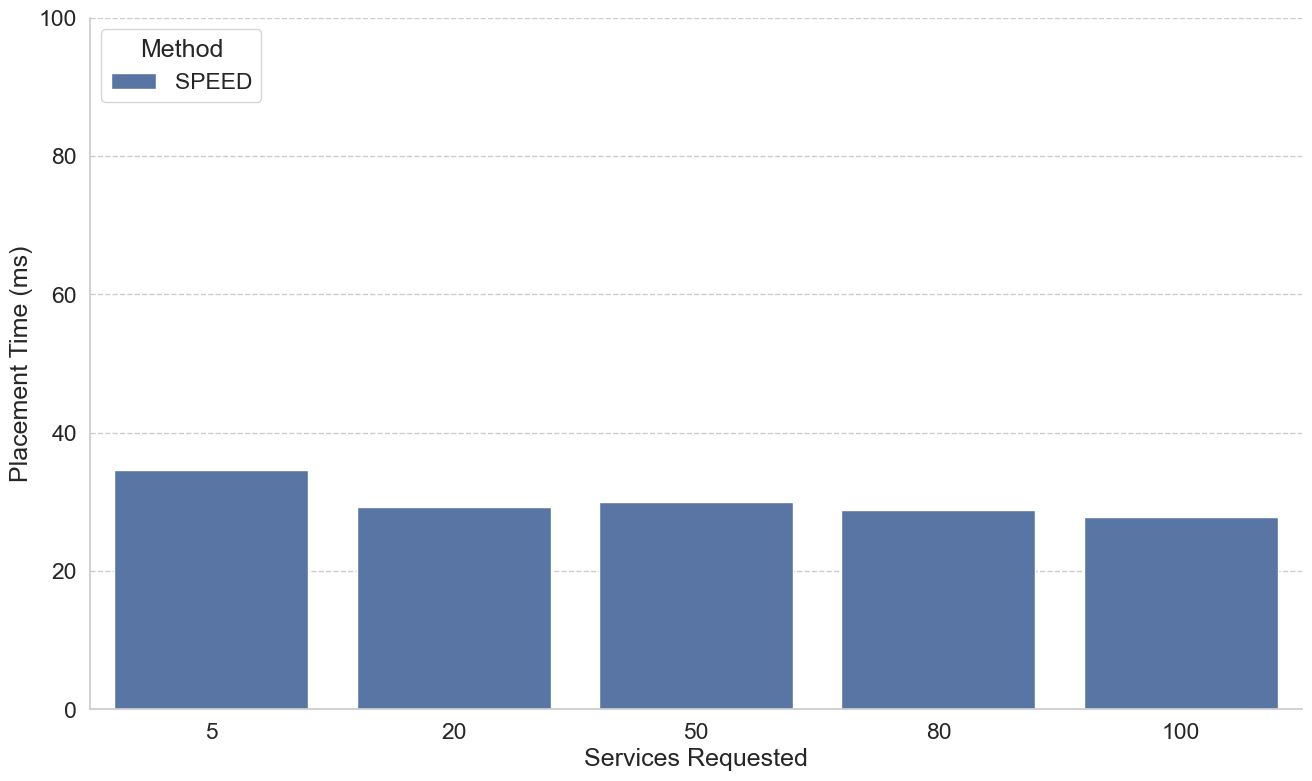

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_placement_time()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    x="Num_Requests",
    y="Placement_Time",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 20),  
    legend_out=False
)

g.set(ylim=(0, 100))

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Placement Time (ms)")
plt.legend(loc='upper left', title='Method')

plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./placement_time.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

# Compute Aggregation Data Size

Compute the size of the data exchanged between the zones to execute the placement

In [87]:
def process_data_size():
    data = load_data()
    entities = data['data_aggregation']
    services_processed = []
    for services in entities:
        df = services.loc[(services['Label'] == "SPEED")]
        services_processed.append(df)

    gd = pd.concat(services_processed)

    gd = gd.groupby(['Label', 'Num_Requests'],  observed=True).sum(["Size"]).reset_index()

    gd["Size"] = gd['Size'] / 100000000

    return gd

data = process_data_size()
data

,Label,Num_Requests,Time,Size,Data,Round
0,SPEED,5,1.694407e+08,6.045002,0.0,203148
1,SPEED,20,5.551667e+08,24.037877,0.0,849816
2,SPEED,50,1.471517e+09,62.361996,0.0,2226972
3,SPEED,80,2.093678e+09,96.221299,0.0,3421440
4,SPEED,100,2.704114e+09,112.384303,0.0,4327488


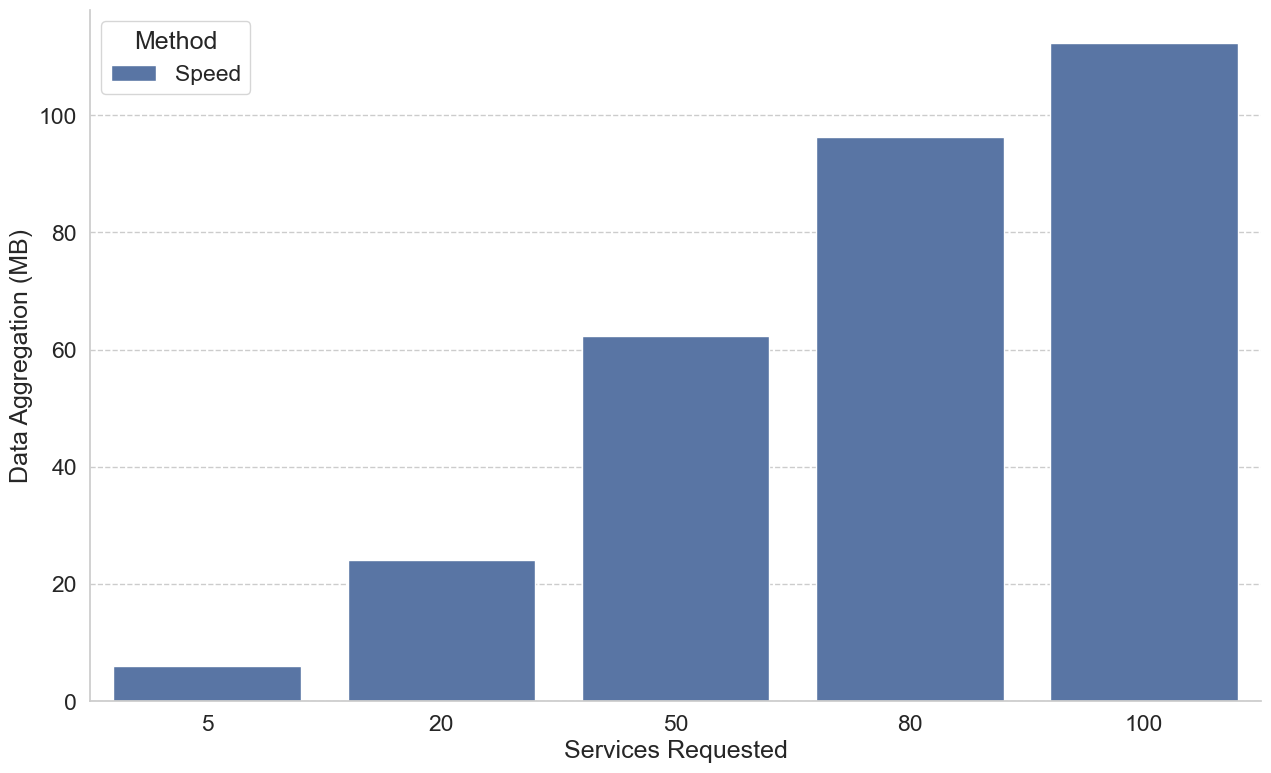

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_size()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    x="Num_Requests",
    y="Size",
    errorbar=('ci', 0.95),
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Data Aggregation (MB)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./data_aggregation_size.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')